In [19]:
import numpy as np
from scipy import stats
# import multiple testing functions
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt

import time
import multiprocessing
from joblib import Parallel, delayed

import sys
sys.path.append('../code/utils/')
from data_generation import *

import psutil

In [20]:
def pvalue_plot_spjotvoll(pvalues, n_max=1000):
    """
    Plot p-values using Schweder and Spjotvoll method
    """
    if len(pvalues) > n_max:
        pvalues = pvalues[np.random.choice(len(pvalues), n_max, replace=False)]
    pvals = np.sort(pvalues)
    N = lambda x: np.mean(pvals > x)
    x = 1 - pvals
    y = np.array([N(i) for i in pvals])
    plt.scatter(x, y)
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlabel('1 - p-values')
    plt.ylabel('Number of p-values > x')
    plt.title('Schweder and Spjotvoll plot')
    plt.show()

In [21]:
def remove_proportion_of_tests_dependent_FDP(Sigma, it=1000, n1=10, n2=10, equal_var=False, prop=0.1, crit='var', shift=0, scale=1):
    
    n = n1+n2
    K = int(prop*it)
    X = np.zeros((it + K, n))
    assert Sigma.shape[0]==(it+K)
    
    for j in range(n1):
        X[:,j] = np.random.multivariate_normal(np.zeros(it+K), Sigma)
    for j in range(n1,n):
        X[:,j] = shift + scale * np.random.multivariate_normal(np.zeros(it+K), Sigma)
        
    if crit=='var':
        crit = np.var(X, axis=1)
    elif crit=='fold-change':
        crit = np.abs(np.mean(X[:,:n1], axis=1)-np.mean(X[:,n1:], axis=1))
    elif crit=='mean':
        crit = np.mean(X, axis=1)
    else:
        raise ValueError('Invalid criterion')
    
    sorted_inds = np.argpartition(crit, K)
    random_inds = np.random.choice(np.arange(it+K), it, replace=False)
    result=stats.ttest_ind(X[sorted_inds[K:],:n1], X[sorted_inds[K:],n1:], equal_var=equal_var, axis=1)
    h_filt = multipletests(result.pvalue, method='fdr_bh')[0]
    result=stats.ttest_ind(X[random_inds,:n1], X[random_inds,n1:], equal_var=False, axis=0)
    h_unfilt = multipletests(result.pvalue, method='fdr_bh')[0]
    
    return np.mean(h_filt), np.mean(h_unfilt)

def remove_proportion_of_tests_dependentV1(Sigma, n1=10, n2=10, equal_var=False, prop=0.1, crit='var', return_n=None, statistic='p', shift=0, scale=1):
    # like the other functions, but now we generate data with given dependence structure Sigma
    
    if statistic=='p':
        extract = lambda x: x.pvalue
    elif statistic=='t':
        extract = lambda x: x.statistic
    elif statistic=='df':
        extract = lambda x: x.df
    else:
        # raise an error if the statistic is not recognized
        raise ValueError('Invalid statistic')
    
    it = Sigma.shape[0]
    n = n1+n2
    K = int(prop*it)
    X = np.zeros((it, n))
    
    for j in range(n1):
        X[:,j] = np.random.multivariate_normal(np.zeros(it), Sigma)
    for j in range(n1,n):
        X[:,j] = shift + scale*np.random.multivariate_normal(np.zeros(it), Sigma)
        
    if crit=='var':
        crit = np.var(X, axis=1)
    elif crit=='fold-change':
        crit = np.abs(np.mean(X[:,:n1], axis=1)-np.mean(X[:,n1:], axis=1))
    elif crit=='mean':
        crit = np.mean(X, axis=1)
    else:
        raise ValueError('Invalid criterion')
    
    #sorted_inds = np.argsort(crit)
    sorted_inds = np.argpartition(crit, K)
    
    X = X[sorted_inds[K:],:]
    result=stats.ttest_ind(X[:,:n1], X[:,n1:], equal_var=equal_var, axis=1)
    result = extract(result)
    
    if return_n is None:
        return result
    
    inds_filtered = np.argpartition(result, return_n)
    result = np.sort(result[inds_filtered[:return_n]])
    return result

def remove_proportion_of_tests_dependentV2(foo, n1=10, n2=10, equal_var=False, prop=0.1, crit='var', return_n=None, statistic='p', shift=0, scale=1):
    # like the other functions, but now we generate data with given dependence structure Sigma
    
    if statistic=='p':
        extract = lambda x: x.pvalue
    elif statistic=='t':
        extract = lambda x: x.statistic
    elif statistic=='df':
        extract = lambda x: x.df
    else:
        # raise an error if the statistic is not recognized
        raise ValueError('Invalid statistic')
    
    # test if foo is callable
    if callable(foo):
        Sigma = foo()
    else:
        Sigma=foo
    it = Sigma.shape[0]
    n = n1+n2
    K = int(prop*it)
    X = np.zeros((it, n))
    
    for j in range(n1):
        X[:,j] = np.random.multivariate_normal(np.zeros(it), Sigma)
    for j in range(n1,n):
        X[:,j] = shift + scale*np.random.multivariate_normal(np.zeros(it), Sigma)
        
    if crit=='var':
        crit = np.var(X, axis=1)
    elif crit=='fold-change':
        crit = np.abs(np.mean(X[:,:n1], axis=1)-np.mean(X[:,n1:], axis=1))
    elif crit=='mean':
        crit = np.mean(X, axis=1)
    else:
        raise ValueError('Invalid criterion')
    
    #sorted_inds = np.argsort(crit)
    sorted_inds = np.argpartition(crit, K)
    
    X = X[sorted_inds[K:],:]
    result=stats.ttest_ind(X[:,:n1], X[:,n1:], equal_var=equal_var, axis=1)
    result = extract(result)
    
    if return_n is None:
        return result
    
    inds_filtered = np.argpartition(result, return_n)
    result = np.sort(result[inds_filtered[:return_n]])
    return result
    

def remove_proportion_of_testsV1(it=1000, n1=10, n2=10, equal_var=False, prop=0, crit='var', return_n=None, statistic='p', shift=0, scale=1):
    # like the other functions, but now we filter out a proportion of the p-values
    # and collect degrees of freedom instead of the t-statistic
    if statistic=='p':
        extract = lambda x: x.pvalue
    elif statistic=='t':
        extract = lambda x: x.statistic
    elif statistic=='df':
        extract = lambda x: x.df
    else:
        # raise an error if the statistic is not recognized
        raise ValueError('Invalid statistic')
    
    n = n1+n2
    K = int(prop*it)
    X = np.zeros((it + K, n))

    for j in range(it + K):
        X[j,:n1] = np.random.normal(0, 1, n1)
        X[j,n1:] = shift + scale * np.random.normal(0, 1, n2)
    if crit=='var':
        crit = np.var(X, axis=1)
    elif crit=='fold-change':
        crit = np.abs(np.mean(X[:,:n1], axis=1)-np.mean(X[:,n1:], axis=1))
    elif crit=='mean':
        crit = np.mean(X, axis=1)
        
    #sorted_inds = np.argsort(crit)
    sorted_inds = np.argpartition(crit, K)
    
    X = X[sorted_inds[K:],:]
    result=stats.ttest_ind(X[:,:n1], X[:,n1:], equal_var=equal_var, axis=1)
    result = extract(result)
    
    if return_n is None or return_n==it:
        return result
    inds_filtered = np.argpartition(result, return_n)
    result = np.sort(result[inds_filtered[:return_n]])

    return result

def remove_proportion_of_testsV2(it=1000, n1=10, n2=10, equal_var=False, prop=0, crit='var', return_n=None, statistic='p', shift=0, equal_scale=False):
    # like the other functions, but now we filter out a proportion of the p-values
    # and collect degrees of freedom instead of the t-statistic
    if statistic=='p':
        extract = lambda x: x.pvalue
    elif statistic=='t':
        extract = lambda x: x.statistic
    elif statistic=='df':
        extract = lambda x: x.df
    else:
        # raise an error if the statistic is not recognized
        raise ValueError('Invalid statistic')
    
    n = n1+n2
    K = int(prop*it)
    X = np.zeros((it + K, n))

    for j in range(it + K):
        # first draw mean and precision from priors
        #mu1 = np.random.normal(0, 1)
        #mu2 = np.random.normal(0, 1)
        mu1 = 0
        mu2 = shift
        prec1 = np.random.gamma(1, 1)
        if equal_scale:
            prec2 = prec1
        else:
            prec2 = np.random.gamma(1, 1)
        X[j,:n1] = np.random.normal(mu1, 1/np.sqrt(prec1), n1)
        X[j,n1:] = np.random.normal(mu2, 1/np.sqrt(prec2), n2)
    
    if crit=='var':
        crit = np.var(X, axis=1)
    elif crit=='fold-change':
        crit = np.abs(np.mean(X[:,:n1], axis=1)-np.mean(X[:,n1:], axis=1))
    elif crit=='mean':
        crit = np.mean(X, axis=1)
        
    #sorted_inds = np.argsort(crit)
    sorted_inds = np.argpartition(crit, K)
    
    X = X[sorted_inds[K:],:]
    result=stats.ttest_ind(X[:,:n1], X[:,n1:], equal_var=equal_var, axis=1)
    result = extract(result)
    
    if return_n is None or return_n==it:
        return result
    inds_filtered = np.argpartition(result, return_n)
    result = np.sort(result[inds_filtered[:return_n]])

    return result

def remove_proportion_of_testsV3(it=1000, n1=10, n2=10, equal_var=False, prop=0, crit='var', return_n=None, statistic='p', shift=0, equal_scale=False):
    # like the previous, but now use chi-squared distribution for the variances
    if statistic=='p':
        extract = lambda x: x.pvalue
    elif statistic=='t':
        extract = lambda x: x.statistic
    elif statistic=='df':
        extract = lambda x: x.df
    else:
        # raise an error if the statistic is not recognized
        raise ValueError('Invalid statistic')
    
    n = n1+n2
    K = int(prop*it)
    X = np.zeros((it + K, n))
    
    for j in range(it + K):
        # first draw mean and precision from priors
        mu1 = 0
        mu2 = shift
        var1 = np.random.chisquare(1)
        if equal_scale:
            var2 = var1
        else:
            var2 = np.random.chisquare(1)
        X[j,:n1] = np.random.normal(mu1, np.sqrt(var1), n1)
        X[j,n1:] = np.random.normal(mu2, np.sqrt(var2), n2)
        
    if crit=='var':
        crit = np.var(X, axis=1)
    elif crit=='fold-change':
        crit = np.abs(np.mean(X[:,:n1], axis=1)-np.mean(X[:,n1:], axis=1))
    elif crit=='mean':
        crit = np.mean(X, axis=1)
        
    #sorted_inds = np.argsort(crit)
    sorted_inds = np.argpartition(crit, K)
    
    X = X[sorted_inds[K:],:]
    result=stats.ttest_ind(X[:,:n1], X[:,n1:], equal_var=equal_var, axis=1)
    result = extract(result)
    
    if return_n is None or return_n==it:
        return result
    inds_filtered = np.argpartition(result, return_n)
    result = np.sort(result[inds_filtered[:return_n]])
    
    return result        



def run_experiment_parallel_method_dependentV1(S,times=20, n_jobs=4, n1=10, n2=10, equal_var=True, prop=0, crit='var', return_n=None, statistic='p', shift=0, scale=1):
    if return_n is None:
        ncols = S.shape[0] - int(prop*S.shape[0])
    else:
        ncols = return_n
    return np.array(Parallel(n_jobs=n_jobs)(delayed(remove_proportion_of_tests_dependentV1)(S,\
        n1=n1, n2=n2, equal_var=equal_var,prop=prop, crit=crit, return_n=return_n, statistic=statistic, shift=shift, scale=scale) for i in range(times))).reshape(times, ncols)

def run_experiment_parallel_methodV1(times=20, n_jobs=4, it=1000, n1=10, n2=10, equal_var=True, prop=0, crit='var', return_n=10, statistic='p', shift=0, scale=1):
    return np.array(Parallel(n_jobs=n_jobs)(delayed(remove_proportion_of_testsV1)(it=it,\
        n1=n1, n2=n2, equal_var=equal_var,prop=prop, crit=crit, return_n=return_n, statistic=statistic, shift=shift, scale=scale) for i in range(times))).reshape(times, return_n)

def run_experiment_parallel_methodV2(times=20, n_jobs=4, it=1000, n1=10, n2=10, equal_var=True, prop=0, crit='var', return_n=10, statistic='p', shift=0, equal_scale=False):
    return np.array(Parallel(n_jobs=n_jobs)(delayed(remove_proportion_of_testsV2)(it=it,\
        n1=n1, n2=n2, equal_var=equal_var, prop=prop, crit=crit, return_n=return_n, statistic=statistic, shift=shift, equal_scale=equal_scale) for i in range(times))).reshape(times, return_n)

def run_experiment_parallel_methodV3(times=20, n_jobs=4, it=1000, n1=10, n2=10, equal_var=True, prop=0, crit='var', return_n=10, statistic='p', shift=0):
    return np.array(Parallel(n_jobs=n_jobs)(delayed(remove_proportion_of_testsV3)(it=it,\
        n1=n1, n2=n2, equal_var=equal_var, prop=prop, crit=crit, return_n=return_n, statistic=statistic, shift=shift) for i in range(times))).reshape(times, return_n)
    

def run_experiment_parallel_method_dependent(foo,times=20, n_jobs=4, n1=10, n2=10, equal_var=True, prop=0, crit='var', return_n=None, statistic='p', shift=0, scale=1):
    if callable(foo):
        N=foo().shape[0]
    else:
        N=foo.shape[0]
    if return_n is None:
        ncols = N - int(prop*N)
    else:
        ncols = return_n
    return np.array(Parallel(n_jobs=n_jobs)(delayed(remove_proportion_of_tests_dependentV2)(foo,\
        n1=n1, n2=n2, equal_var=equal_var,prop=prop, crit=crit, return_n=return_n, statistic=statistic, shift=shift, scale=scale) for i in range(times))).reshape(times, ncols)

In [22]:
plt.rcParams.update({'font.size': 8})

def plot_cases(case1, case2, tit, label1, label2, xlab='p', up=False, path=None, fname=None):
    plt.figure(figsize=(6,4))
    plt.hist(case1.flatten(), bins=100, alpha=0.5, label=label1, density=True)
    plt.hist(case2.flatten(), bins=100, alpha=1, label=label2, histtype=u'step', color='black', density=True)
    # plot the axvlines at 0.05 quantile
    #plt.axvline(np.quantile(res0.flatten(), 0.05), color='blue', linestyle='--', label='0.05 quantile no filter')
    #plt.axvline(np.quantile(res1.flatten(), 0.05), color='red', linestyle='--', label='0.05 quantile filter')
    # put legend at the right bottom
    if up:
        plt.legend(loc='upper right')
    else:
        plt.legend(loc='lower right')
    plt.xlabel(xlab)
    plt.title(tit.split(':')[1])
    
    if path is None:
        plt.show()
    else:
        if fname is None:
            plt.savefig(path + tit.split(':')[0] + '_hist.eps', format='eps')
        else:
            plt.savefig(path + fname)
        plt.close()
    
            
def plot_others(case1, case2, tit='', k=30, path=None, fname=None, M_eff=None):
    it = case1.shape[1]
    n_times= case1.shape[0]
    
    order0 = np.argsort(case1,axis=1)
    order1 = np.argsort(case2,axis=1)
    orderstats0 = case1[np.arange(n_times)[:,None],order0][:,:k]
    orderstats1 = case2[np.arange(n_times)[:,None],order1][:,:k]
    
    # plot the order statistics with boxplots
    plt.figure(figsize=(14,5))
    plt.boxplot(orderstats0, positions=np.arange(1,k+1)-0.1, flierprops=dict(marker='o', color='r'))
    plt.plot(np.arange(1,k+1), np.arange(1,k+1)/it, 'k', label='Theoretical')
    
    if M_eff is not None:
        plt.plot(np.arange(1,k+1), np.arange(1,k+1)/M_eff, 'r--', label='M_eff adjusted')

    bp1 = plt.boxplot(orderstats1, positions=np.arange(1,k+1)+0.1, flierprops=dict(marker='x', color='r'), patch_artist=True)
    for box in bp1['boxes']:
        box.set_facecolor('green') # set color for second boxplot
        box.set_alpha(0.2) # set transparency for second boxplot

    plt.xticks(np.arange(1,k+1)+0.05, np.arange(1,k+1))
    plt.xlabel('k')
    plt.ylabel('p-value')
    plt.legend()
    plt.title(tit.split(':')[1])
    
    if path is None:
        plt.show()
    else:
        if fname is None:
            plt.savefig(path + tit.split(':')[0] + '_box.eps', format='eps')
        else:
            plt.savefig(path + fname)
        plt.close()
    

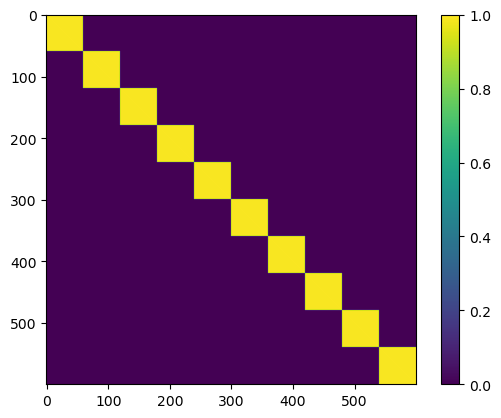

In [324]:
#S=generate_equicovariance_matrix(20, 1, 0.9)
it=1000
S=make_equi_block_covariance(it, 10, 0.99, np.ones(it))
#S=np.eye(20)

plt.imshow(S)
plt.colorbar()
plt.show()

In [ ]:
#res0=run_experiment_parallel_method_dependent(S, times=n_times, n_jobs=n_jobs, n1=10, n2=10, equal_var=False, prop=0.5, crit='var', return_n=None, statistic='p', shift=0, scale=2)
#res1=run_experiment_parallel_method_dependent(S, times=n_times, n_jobs=8, n1=10, n2=10, equal_var=True, prop=0.5, crit='var', return_n=None, statistic='p', shift=0, scale=1)


#res0=run_experiment_parallel_methodV2(times=n_times, it=it, n1=10, n2=10, equal_var=False, prop=0, crit='var', return_n=it, statistic='p', shift=0)
#res1=run_experiment_parallel_methodV2(times=n_times, it=it, n1=10, n2=10, equal_var=False, prop=0.5, crit='var', return_n=it, statistic='p', shift=0)

#res0=run_experiment_parallel_methodV3(times=n_times, it=it, n1=10, n2=10, equal_var=False, prop=0, crit='var', return_n=it, statistic='p', shift=0)
#res1=run_experiment_parallel_methodV3(times=n_times, it=it, n1=10, n2=10, equal_var=False, prop=0.5, crit='var', return_n=it, statistic='p', shift=0)

In [505]:
#### Cases with independent data with equal variance

In [23]:
n_times=1000
it=1000
n_jobs = psutil.cpu_count(logical=False)
label0='independent, no filtering'
label1='independent, filtered'

pathout = '../results/plots/synthetic_data_simulations/independent_filter/'

In [602]:
# No effects
tit = 'CASE 1: Strong var filter (50%), equal variances test, shift 0/0, scale 1/1'
res0=run_experiment_parallel_methodV1(times=n_times, n_jobs=n_jobs, it=it, n1=10, n2=10, equal_var=True, prop=0, crit='var', return_n=it, statistic='p', shift=0, scale=1)
res1=run_experiment_parallel_methodV1(times=n_times, n_jobs=n_jobs, it=it, n1=10, n2=10, equal_var=True, prop=0.5, crit='var', return_n=it, statistic='p', shift=0, scale=1)
plot_cases(res0, res1, tit, label0,label1, path=pathout)
plot_others(res0, res1, tit + " (green is filtered)", k=20, path=pathout)

tit = 'CASE 2: Strong var filter (50%), unequal variances test, shift 0/0, scale 1/1' 
res0=run_experiment_parallel_methodV1(times=n_times, n_jobs=n_jobs, it=it, n1=10, n2=10, equal_var=False, prop=0, crit='var', return_n=it, statistic='p', shift=0, scale=1)
res1=run_experiment_parallel_methodV1(times=n_times, n_jobs=n_jobs, it=it, n1=10, n2=10, equal_var=False, prop=0.5, crit='var', return_n=it, statistic='p', shift=0, scale=1)
plot_cases(res0, res1, tit, label0,label1, path=pathout)
plot_others(res0, res1, tit + " (green is filtered)", k=20, path=pathout)

tit = 'CASE 3: Strong var filter (50%), equal variances test, shift 0/0, scale 1/2'
res0=run_experiment_parallel_methodV1(times=n_times, n_jobs=n_jobs, it=it, n1=10, n2=10, equal_var=True, prop=0, crit='var', return_n=it, statistic='p', shift=0, scale=2)
res1=run_experiment_parallel_methodV1(times=n_times, n_jobs=n_jobs, it=it, n1=10, n2=10, equal_var=True, prop=0.5, crit='var', return_n=it, statistic='p', shift=0, scale=2)
plot_cases(res0, res1, tit, label0,label1, path=pathout)
plot_others(res0, res1, tit + " (green is filtered)", k=20, path=pathout)

tit = 'CASE 4: Strong mean filter (50%), equal variances test, shift 0/0, scale 1/1'
res0=run_experiment_parallel_methodV1(times=n_times, n_jobs=n_jobs, it=it, n1=10, n2=10, equal_var=True, prop=0, crit='mean', return_n=it, statistic='p', shift=0, scale=1)
res1=run_experiment_parallel_methodV1(times=n_times, n_jobs=n_jobs, it=it, n1=10, n2=10, equal_var=True, prop=0.5, crit='mean', return_n=it, statistic='p', shift=0, scale=1)
plot_cases(res0, res1, tit, label0,label1, path=pathout)
plot_others(res0, res1, tit + " (green is filtered)", k=20, path=pathout)

tit = 'CASE 5: Strong mean filter (50%), unequal variances test, shift 0/0, scale 1/1'
res0=run_experiment_parallel_methodV1(times=n_times, n_jobs=n_jobs, it=it, n1=10, n2=10, equal_var=False, prop=0, crit='mean', return_n=it, statistic='p', shift=0, scale=1)
res1=run_experiment_parallel_methodV1(times=n_times, n_jobs=n_jobs, it=it, n1=10, n2=10, equal_var=False, prop=0.5, crit='mean', return_n=it, statistic='p', shift=0, scale=1)
plot_cases(res0, res1, tit, label0,label1, path=pathout)
plot_others(res0, res1, tit + " (green is filtered)", k=20, path=pathout)

tit = 'CASE 6: Strong mean filter (50%), equal variances test, shift 0/0, scale 1/2'
res0=run_experiment_parallel_methodV1(times=n_times, n_jobs=n_jobs, it=it, n1=10, n2=10, equal_var=True, prop=0, crit='mean', return_n=it, statistic='p', shift=0, scale=2)
res1=run_experiment_parallel_methodV1(times=n_times, n_jobs=n_jobs, it=it, n1=10, n2=10, equal_var=True, prop=0.5, crit='mean', return_n=it, statistic='p', shift=0, scale=2)
plot_cases(res0, res1, tit, label0,label1, path=pathout)
plot_others(res0, res1, tit + " (green is filtered)", k=20, path=pathout)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

In [605]:
# No effects
tit = 'CASE 7: Strong var filter (50%), unequal variances test, shift 0/0, scale 1/2'
res0=run_experiment_parallel_methodV1(times=n_times, n_jobs=n_jobs, it=it, n1=10, n2=10, equal_var=False, prop=0, crit='var', return_n=it, statistic='p', shift=0, scale=2)
res1=run_experiment_parallel_methodV1(times=n_times, n_jobs=n_jobs, it=it, n1=10, n2=10, equal_var=False, prop=0.5, crit='var', return_n=it, statistic='p', shift=0, scale=2)
plot_cases(res0, res1, tit, label0,label1, path=pathout)
plot_others(res0, res1, tit + " (green is filtered)", k=20, path=pathout)

tit = 'CASE 8: Weak var filter (10%), unequal variances test, shift 0/0, scale 1/2'
res0=run_experiment_parallel_methodV1(times=n_times, n_jobs=n_jobs, it=it, n1=10, n2=10, equal_var=False, prop=0, crit='var', return_n=it, statistic='p', shift=0, scale=2)
res1=run_experiment_parallel_methodV1(times=n_times, n_jobs=n_jobs, it=it, n1=10, n2=10, equal_var=False, prop=0.1, crit='var', return_n=it, statistic='p', shift=0, scale=2)
plot_cases(res0, res1, tit, label0,label1, path=pathout)
plot_others(res0, res1, tit + " (green is filtered)", k=20, path=pathout)

tit = 'CASE 9: Strong mean filter (50%), unequal variances test, shift 0/0, scale 1/2'
res0=run_experiment_parallel_methodV1(times=n_times, n_jobs=n_jobs, it=it, n1=10, n2=10, equal_var=False, prop=0, crit='mean', return_n=it, statistic='p', shift=0, scale=2)
res1=run_experiment_parallel_methodV1(times=n_times, n_jobs=n_jobs, it=it, n1=10, n2=10, equal_var=False, prop=0.5, crit='mean', return_n=it, statistic='p', shift=0, scale=2)
plot_cases(res0, res1, tit, label0,label1, path=pathout)
plot_others(res0, res1, tit + " (green is filtered)", k=20, path=pathout)

tit = 'CASE 10: Weak mean filter (10%), unequal variances test, shift 0/0, scale 1/2'
res0=run_experiment_parallel_methodV1(times=n_times, n_jobs=n_jobs, it=it, n1=10, n2=10, equal_var=False, prop=0, crit='mean', return_n=it, statistic='p', shift=0, scale=2)
res1=run_experiment_parallel_methodV1(times=n_times, n_jobs=n_jobs, it=it, n1=10, n2=10, equal_var=False, prop=0.1, crit='mean', return_n=it, statistic='p', shift=0, scale=2)
plot_cases(res0, res1, tit, label0,label1, path=pathout)
plot_others(res0, res1, tit + " (green is filtered)", k=20, path=pathout)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [607]:
# No effects
tit = 'CASE 11: Very weak var filter (2%), unequal variances test, shift 0/0, scale 1/2'
res0=run_experiment_parallel_methodV1(times=n_times, n_jobs=n_jobs, it=it, n1=10, n2=10, equal_var=False, prop=0, crit='var', return_n=it, statistic='p', shift=0, scale=2)
res1=run_experiment_parallel_methodV1(times=n_times, n_jobs=n_jobs, it=it, n1=10, n2=10, equal_var=False, prop=0.02, crit='var', return_n=it, statistic='p', shift=0, scale=2)
plot_cases(res0, res1, tit, label0,label1, path=pathout)
plot_others(res0, res1, tit + " (green is filtered)", k=20, path=pathout)

tit = 'CASE 12: Very weak var filter (2%), unequal variances test, shift 0/0, scale 1/5'
res0=run_experiment_parallel_methodV1(times=n_times, n_jobs=n_jobs, it=it, n1=10, n2=10, equal_var=False, prop=0, crit='var', return_n=it, statistic='p', shift=0, scale=5)
res1=run_experiment_parallel_methodV1(times=n_times, n_jobs=n_jobs, it=it, n1=10, n2=10, equal_var=False, prop=0.02, crit='var', return_n=it, statistic='p', shift=0, scale=5)
plot_cases(res0, res1, tit, label0,label1, path=pathout)
plot_others(res0, res1, tit + " (green is filtered)", k=20, path=pathout)

tit = 'CASE 13: Very weak mean filter (2%), unequal variances test, shift 0/0, scale 1/2'
res0=run_experiment_parallel_methodV1(times=n_times, n_jobs=n_jobs, it=it, n1=10, n2=10, equal_var=False, prop=0, crit='mean', return_n=it, statistic='p', shift=0, scale=2)
res1=run_experiment_parallel_methodV1(times=n_times, n_jobs=n_jobs, it=it, n1=10, n2=10, equal_var=False, prop=0.02, crit='mean', return_n=it, statistic='p', shift=0, scale=2)
plot_cases(res0, res1, tit, label0,label1, path=pathout)
plot_others(res0, res1, tit + " (green is filtered)", k=20, path=pathout)

tit = 'CASE 14: Very weak mean filter (2%), unequal variances test, shift 0/0, scale 1/5'
res0=run_experiment_parallel_methodV1(times=n_times, n_jobs=n_jobs, it=it, n1=10, n2=10, equal_var=False, prop=0, crit='mean', return_n=it, statistic='p', shift=0, scale=5)
res1=run_experiment_parallel_methodV1(times=n_times, n_jobs=n_jobs, it=it, n1=10, n2=10, equal_var=False, prop=0.02, crit='mean', return_n=it, statistic='p', shift=0, scale=5)
plot_cases(res0, res1, tit, label0,label1, path=pathout)
plot_others(res0, res1, tit + " (green is filtered)", k=20, path=pathout)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [608]:
# Effects
tit = 'CASE 15: Strong var filter (50%), equal variances test, shift 0/0.5, scale 1/1'
res0=run_experiment_parallel_methodV1(times=n_times, n_jobs=n_jobs, it=it, n1=10, n2=10, equal_var=True, prop=0, crit='var', return_n=it, statistic='p', shift=.5, scale=1)
res1=run_experiment_parallel_methodV1(times=n_times, n_jobs=n_jobs, it=it, n1=10, n2=10, equal_var=True, prop=0.5, crit='var', return_n=it, statistic='p', shift=.5, scale=1)
plot_cases(res0,res1, tit, label0, label1, 'p', True, path=pathout)

tit = 'CASE 16: Strong var filter (50%), unequal variances test, shift 0/0.5, scale 1/1'
res0=run_experiment_parallel_methodV1(times=n_times, n_jobs=n_jobs, it=it, n1=10, n2=10, equal_var=False, prop=0, crit='var', return_n=it, statistic='p', shift=.5, scale=1)
res1=run_experiment_parallel_methodV1(times=n_times, n_jobs=n_jobs, it=it, n1=10, n2=10, equal_var=False, prop=0.5, crit='var', return_n=it, statistic='p', shift=.5, scale=1)
plot_cases(res0,res1, tit, label0, label1, 'p', True, path=pathout)

tit = 'CASE 17: Strong var filter (50%), unequal variances test, shift 0/0.5, scale 1/2'
res0=run_experiment_parallel_methodV1(times=n_times, n_jobs=n_jobs, it=it, n1=10, n2=10, equal_var=False, prop=0, crit='var', return_n=it, statistic='p', shift=.5, scale=2)
res1=run_experiment_parallel_methodV1(times=n_times, n_jobs=n_jobs, it=it, n1=10, n2=10, equal_var=False, prop=0.5, crit='var', return_n=it, statistic='p', shift=.5, scale=2)
plot_cases(res0,res1, tit, label0, label1, 'p', True, path=pathout)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [609]:
# Effects
tit = 'CASE 18: Strong mean filter (50%), equal variances test, shift 0/0.5, scale 1/1'
res0=run_experiment_parallel_methodV1(times=n_times, n_jobs=n_jobs, it=it, n1=10, n2=10, equal_var=True, prop=0, crit='mean', return_n=it, statistic='p', shift=.5, scale=1)
res1=run_experiment_parallel_methodV1(times=n_times, n_jobs=n_jobs, it=it, n1=10, n2=10, equal_var=True, prop=0.5, crit='mean', return_n=it, statistic='p', shift=.5, scale=1)
plot_cases(res0,res1, tit, label0, label1, 'p', True, path=pathout)

tit = 'CASE 19: Strong mean filter (50%), unequal variances test, shift 0/0.5, scale 1/1'
res0=run_experiment_parallel_methodV1(times=n_times, n_jobs=n_jobs, it=it, n1=10, n2=10, equal_var=False, prop=0, crit='mean', return_n=it, statistic='p', shift=.5, scale=1)
res1=run_experiment_parallel_methodV1(times=n_times, n_jobs=n_jobs, it=it, n1=10, n2=10, equal_var=False, prop=0.5, crit='mean', return_n=it, statistic='p', shift=.5, scale=1)
plot_cases(res0,res1, tit, label0, label1, 'p', True, path=pathout)

tit = 'CASE 20: Strong mean filter (50%), unequal variances test, shift 0/0.5, scale 1/2'
res0=run_experiment_parallel_methodV1(times=n_times, n_jobs=n_jobs, it=it, n1=10, n2=10, equal_var=False, prop=0, crit='mean', return_n=it, statistic='p', shift=.5, scale=2)
res1=run_experiment_parallel_methodV1(times=n_times, n_jobs=n_jobs, it=it, n1=10, n2=10, equal_var=False, prop=0.5, crit='mean', return_n=it, statistic='p', shift=.5, scale=2)
plot_cases(res0,res1, tit, label0, label1, 'p', True, path=pathout)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [610]:
# Effects
tit = 'CASE 21: Weak fold-change filter (10%), equal variances test, shift 0/0.5, scale 1/1'
res0=run_experiment_parallel_methodV1(times=n_times, n_jobs=n_jobs, it=it, n1=10, n2=10, equal_var=True, prop=0, crit='fold-change', return_n=it, statistic='p', shift=.5, scale=1)
res1=run_experiment_parallel_methodV1(times=n_times, n_jobs=n_jobs, it=it, n1=10, n2=10, equal_var=True, prop=0.1, crit='fold-change', return_n=it, statistic='p', shift=.5, scale=1)
plot_cases(res0,res1, tit, label0, label1, 'p', True, path=pathout)

tit = 'CASE 22: Weak fold-change filter (10%), unequal variances test, shift 0/0.5, scale 1/1'
res0=run_experiment_parallel_methodV1(times=n_times, n_jobs=n_jobs, it=it, n1=10, n2=10, equal_var=False, prop=0, crit='fold-change', return_n=it, statistic='p', shift=.5, scale=1)
res1=run_experiment_parallel_methodV1(times=n_times, n_jobs=n_jobs, it=it, n1=10, n2=10, equal_var=False, prop=0.1, crit='fold-change', return_n=it, statistic='p', shift=.5, scale=1)
plot_cases(res0,res1, tit, label0, label1, 'p', True, path=pathout)

tit = 'CASE 23: Weak fold-change filter (10%), unequal variances test, shift 0/0.5, scale 1/2'
res0=run_experiment_parallel_methodV1(times=n_times, n_jobs=n_jobs, it=it, n1=10, n2=10, equal_var=False, prop=0, crit='fold-change', return_n=it, statistic='p', shift=.5, scale=2)
res1=run_experiment_parallel_methodV1(times=n_times, n_jobs=n_jobs, it=it, n1=10, n2=10, equal_var=False, prop=0.1, crit='fold-change', return_n=it, statistic='p', shift=.5, scale=2)
plot_cases(res0,res1, tit, label0, label1, 'p', True, path=pathout)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [ ]:
# No effects
tit = 'CASE24: Strong var filter (50%), equal variances test, shift 0/0, equal variances'
res0=run_experiment_parallel_methodV2(times=n_times, n_jobs=n_jobs, it=it, n1=10, n2=10, equal_var=True, prop=0, crit='var', return_n=it, statistic='p', shift=0, equal_scale=True)
res1=run_experiment_parallel_methodV2(times=n_times, n_jobs=n_jobs, it=it, n1=10, n2=10, equal_var=True, prop=0.5, crit='var', return_n=it, statistic='p', shift=0, equal_scale=True)
plot_cases(res0, res1, tit, label0,label1, path=pathout)
plot_others(res0, res1, tit + " (green is filtered)", k=20, path=pathout)

tit = 'CASE25: Strong var filter (50%), unequal variances test, shift 0/0, equal variances' 
res0=run_experiment_parallel_methodV2(times=n_times, n_jobs=n_jobs, it=it, n1=10, n2=10, equal_var=False, prop=0, crit='var', return_n=it, statistic='p', shift=0,  equal_scale=True)
res1=run_experiment_parallel_methodV2(times=n_times, n_jobs=n_jobs, it=it, n1=10, n2=10, equal_var=False, prop=0.5, crit='var', return_n=it, statistic='p', shift=0,  equal_scale=True)
plot_cases(res0, res1, tit, label0,label1, path=pathout)
plot_others(res0, res1, tit + " (green is filtered)", k=20, path=pathout)

tit = 'CASE26: Strong var filter (50%), equal variances test, shift 0/0, unequal variances'
res0=run_experiment_parallel_methodV2(times=n_times, n_jobs=n_jobs, it=it, n1=10, n2=10, equal_var=True, prop=0, crit='mean', return_n=it, statistic='p', shift=0, equal_scale=False)
res1=run_experiment_parallel_methodV2(times=n_times, n_jobs=n_jobs, it=it, n1=10, n2=10, equal_var=True, prop=0.5, crit='mean', return_n=it, statistic='p', shift=0, equal_scale=False)
plot_cases(res0, res1, tit, label0,label1, path=pathout)
plot_others(res0, res1, tit + " (green is filtered)", k=20, path=pathout)

tit = 'CASE27: Strong var filter (50%), unequal variances test, shift 0/0, unequal variances'
res0=run_experiment_parallel_methodV2(times=n_times, n_jobs=n_jobs, it=it, n1=10, n2=10, equal_var=False, prop=0, crit='mean', return_n=it, statistic='p', shift=0, equal_scale=False)
res1=run_experiment_parallel_methodV2(times=n_times, n_jobs=n_jobs, it=it, n1=10, n2=10, equal_var=False, prop=0.5, crit='mean', return_n=it, statistic='p', shift=0, equal_scale=False)
plot_cases(res0, res1, tit, label0,label1, path=pathout)
plot_others(res0, res1, tit + " (green is filtered)", k=20, path=pathout)

tit = 'CASE28: Strong mean filter (50%), equal variances test, shift 0/0, equal variances'
res0=run_experiment_parallel_methodV2(times=n_times, n_jobs=n_jobs, it=it, n1=10, n2=10, equal_var=True, prop=0, crit='mean', return_n=it, statistic='p', shift=0, equal_scale=True)
res1=run_experiment_parallel_methodV2(times=n_times, n_jobs=n_jobs, it=it, n1=10, n2=10, equal_var=True, prop=0.5, crit='mean', return_n=it, statistic='p', shift=0, equal_scale=True)
plot_cases(res0, res1, tit, label0,label1, path=pathout)
plot_others(res0, res1, tit + " (green is filtered)", k=20, path=pathout)

tit = 'CASE29: Strong mean filter (50%), unequal variances test, shift 0/0, equal variances'
res0=run_experiment_parallel_methodV2(times=n_times, n_jobs=n_jobs, it=it, n1=10, n2=10, equal_var=False, prop=0, crit='mean', return_n=it, statistic='p', shift=0, equal_scale=True)
res1=run_experiment_parallel_methodV2(times=n_times, n_jobs=n_jobs, it=it, n1=10, n2=10, equal_var=False, prop=0.5, crit='mean', return_n=it, statistic='p', shift=0, equal_scale=True)
plot_cases(res0, res1, tit, label0,label1, path=pathout)
plot_others(res0, res1, tit + " (green is filtered)", k=20, path=pathout)

tit = 'CASE30: Strong mean filter (50%), equal variances test, shift 0/0, unequal variances'
res0=run_experiment_parallel_methodV2(times=n_times, n_jobs=n_jobs, it=it, n1=10, n2=10, equal_var=True, prop=0, crit='mean', return_n=it, statistic='p', shift=0, equal_scale=False)
res1=run_experiment_parallel_methodV2(times=n_times, n_jobs=n_jobs, it=it, n1=10, n2=10, equal_var=True, prop=0.5, crit='mean', return_n=it, statistic='p', shift=0, equal_scale=False)
plot_cases(res0, res1, tit, label0,label1, path=pathout)
plot_others(res0, res1, tit + " (green is filtered)", k=20, path=pathout)

tit = 'CASE31: Strong mean filter (50%), unequal variances test, shift 0/0, unequal variances'
res0=run_experiment_parallel_methodV2(times=n_times, n_jobs=n_jobs, it=it, n1=10, n2=10, equal_var=False, prop=0, crit='mean', return_n=it, statistic='p', shift=0, equal_scale=False)
res1=run_experiment_parallel_methodV2(times=n_times, n_jobs=n_jobs, it=it, n1=10, n2=10, equal_var=False, prop=0.5, crit='mean', return_n=it, statistic='p', shift=0, equal_scale=False)
plot_cases(res0, res1, tit, label0,label1, path=pathout)
plot_others(res0, res1, tit + " (green is filtered)", k=20, path=pathout)

In [24]:
# Effects
tit = 'CASE32: Strong var filter (50%), equal variances test, shift 0.5/0.5, equal variances'
res0=run_experiment_parallel_methodV2(times=n_times, n_jobs=n_jobs, it=it, n1=10, n2=10, equal_var=True, prop=0, crit='var', return_n=it, statistic='p', shift=0.5, equal_scale=True)
res1=run_experiment_parallel_methodV2(times=n_times, n_jobs=n_jobs, it=it, n1=10, n2=10, equal_var=True, prop=0.5, crit='var', return_n=it, statistic='p', shift=0.5, equal_scale=True)
plot_cases(res0, res1, tit, label0,label1, path=pathout)

tit = 'CASE33: Strong var filter (50%), unequal variances test, shift 0.5/0.5, equal variances' 
res0=run_experiment_parallel_methodV2(times=n_times, n_jobs=n_jobs, it=it, n1=10, n2=10, equal_var=False, prop=0, crit='var', return_n=it, statistic='p', shift=0.5,  equal_scale=True)
res1=run_experiment_parallel_methodV2(times=n_times, n_jobs=n_jobs, it=it, n1=10, n2=10, equal_var=False, prop=0.5, crit='var', return_n=it, statistic='p', shift=0.5,  equal_scale=True)
plot_cases(res0, res1, tit, label0,label1, path=pathout)

tit = 'CASE34: Strong var filter (50%), equal variances test, shift 0.5/0.5, unequal variances'
res0=run_experiment_parallel_methodV2(times=n_times, n_jobs=n_jobs, it=it, n1=10, n2=10, equal_var=True, prop=0, crit='mean', return_n=it, statistic='p', shift=0.5, equal_scale=False)
res1=run_experiment_parallel_methodV2(times=n_times, n_jobs=n_jobs, it=it, n1=10, n2=10, equal_var=True, prop=0.5, crit='mean', return_n=it, statistic='p', shift=0.5, equal_scale=False)
plot_cases(res0, res1, tit, label0,label1, path=pathout)

tit = 'CASE35: Strong var filter (50%), unequal variances test, shift 0.5/0.5, unequal variances'
res0=run_experiment_parallel_methodV2(times=n_times, n_jobs=n_jobs, it=it, n1=10, n2=10, equal_var=False, prop=0, crit='mean', return_n=it, statistic='p', shift=0.5, equal_scale=False)
res1=run_experiment_parallel_methodV2(times=n_times, n_jobs=n_jobs, it=it, n1=10, n2=10, equal_var=False, prop=0.5, crit='mean', return_n=it, statistic='p', shift=0.5, equal_scale=False)
plot_cases(res0, res1, tit, label0,label1, path=pathout)

tit = 'CASE36: Strong mean filter (50%), equal variances test, shift 0.5/0.5, equal variances'
res0=run_experiment_parallel_methodV2(times=n_times, n_jobs=n_jobs, it=it, n1=10, n2=10, equal_var=True, prop=0, crit='mean', return_n=it, statistic='p', shift=0.5, equal_scale=True)
res1=run_experiment_parallel_methodV2(times=n_times, n_jobs=n_jobs, it=it, n1=10, n2=10, equal_var=True, prop=0.5, crit='mean', return_n=it, statistic='p', shift=0.5, equal_scale=True)
plot_cases(res0, res1, tit, label0,label1, path=pathout)

tit = 'CASE37: Strong mean filter (50%), unequal variances test, shift 0.5/0.5, equal variances'
res0=run_experiment_parallel_methodV2(times=n_times, n_jobs=n_jobs, it=it, n1=10, n2=10, equal_var=False, prop=0, crit='mean', return_n=it, statistic='p', shift=0.5, equal_scale=True)
res1=run_experiment_parallel_methodV2(times=n_times, n_jobs=n_jobs, it=it, n1=10, n2=10, equal_var=False, prop=0.5, crit='mean', return_n=it, statistic='p', shift=0.5, equal_scale=True)
plot_cases(res0, res1, tit, label0,label1, path=pathout)

tit = 'CASE38: Strong mean filter (50%), equal variances test, shift 0.5/0.5, unequal variances'
res0=run_experiment_parallel_methodV2(times=n_times, n_jobs=n_jobs, it=it, n1=10, n2=10, equal_var=True, prop=0, crit='mean', return_n=it, statistic='p', shift=0.5, equal_scale=False)
res1=run_experiment_parallel_methodV2(times=n_times, n_jobs=n_jobs, it=it, n1=10, n2=10, equal_var=True, prop=0.5, crit='mean', return_n=it, statistic='p', shift=0.5, equal_scale=False)
plot_cases(res0, res1, tit, label0,label1, path=pathout)

tit = 'CASE39: Strong mean filter (50%), unequal variances test, shift 0.5/0.5, unequal variances'
res0=run_experiment_parallel_methodV2(times=n_times, n_jobs=n_jobs, it=it, n1=10, n2=10, equal_var=False, prop=0, crit='mean', return_n=it, statistic='p', shift=0.5, equal_scale=False)
res1=run_experiment_parallel_methodV2(times=n_times, n_jobs=n_jobs, it=it, n1=10, n2=10, equal_var=False, prop=0.5, crit='mean', return_n=it, statistic='p', shift=0.5, equal_scale=False)
plot_cases(res0, res1, tit, label0,label1, path=pathout)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [ ]:
### Dependent data

In [645]:
n_times=1000
n_jobs = psutil.cpu_count(logical=False)
label0='independent, filtered'
label1='dependent, filtered'

pathout = '../results/plots/synthetic_data_simulations/dependent_filter/'

it=500
prop=0.5
S0=np.eye(it)#np.eye(it - int(prop*it))

S1= lambda: make_equi_block_covariance(it, it//2, 0.95, np.ones(it))
tit = 'CASE40: +0.95 bi-block , var filter (50%), equal variances test, shift 0/0, scale 1/1'
res0=run_experiment_parallel_method_dependent(S0, times=n_times, n_jobs=8, n1=10, n2=10, equal_var=True, prop=prop, crit='var', return_n=None, statistic='p', shift=0, scale=1)
res1=run_experiment_parallel_method_dependent(S1, times=n_times, n_jobs=8, n1=10, n2=10, equal_var=True, prop=prop, crit='var', return_n=None, statistic='p', shift=0, scale=1)
plot_cases(res0, res1, tit, label0,label1, path=pathout)
plot_others(res0, res1, tit + " (green is dependent)", k=20, path=pathout)

S1= lambda: make_equi_block_covariance(it, it//3, 0.5, np.ones(it))
tit = 'CASE41: +0.5 tri-block , var filter (50%), equal variances test, shift 0/0, scale 1/1'
res0=run_experiment_parallel_method_dependent(S0, times=n_times, n_jobs=8, n1=10, n2=10, equal_var=True, prop=prop, crit='var', return_n=None, statistic='p', shift=0, scale=1)
res1=run_experiment_parallel_method_dependent(S1, times=n_times, n_jobs=8, n1=10, n2=10, equal_var=True, prop=prop, crit='var', return_n=None, statistic='p', shift=0, scale=1)
plot_cases(res0, res1, tit, label0,label1, path=pathout)
plot_others(res0, res1, tit + " (green is dependent)", k=20, path=pathout)

S1= lambda: make_equi_block_covariance(it, it//2, -0.95, np.ones(it))
tit = 'CASE42: -0.95 bi-block , var filter (50%), equal variances test, shift 0/0, scale 1/1'
res0=run_experiment_parallel_method_dependent(S0, times=n_times, n_jobs=8, n1=10, n2=10, equal_var=True, prop=prop, crit='var', return_n=None, statistic='p', shift=0, scale=1)
res1=run_experiment_parallel_method_dependent(S1, times=n_times, n_jobs=8, n1=10, n2=10, equal_var=True, prop=prop, crit='var', return_n=None, statistic='p', shift=0, scale=1)
plot_cases(res0, res1, tit, label0,label1, path=pathout)
plot_others(res0, res1, tit + " (green is dependent)", k=20, path=pathout)

S1= lambda: make_equi_block_covariance(it, it//3, -0.5, np.ones(it))
tit = 'CASE43: -0.5 tri-block , var filter (50%), equal variances test, shift 0/0, scale 1/1'
res0=run_experiment_parallel_method_dependent(S0, times=n_times, n_jobs=8, n1=10, n2=10, equal_var=True, prop=prop, crit='var', return_n=None, statistic='p', shift=0, scale=1)
res1=run_experiment_parallel_method_dependent(S1, times=n_times, n_jobs=8, n1=10, n2=10, equal_var=True, prop=prop, crit='var', return_n=None, statistic='p', shift=0, scale=1)
plot_cases(res0, res1, tit, label0,label1, path=pathout)
plot_others(res0, res1, tit + " (green is dependent)", k=20, path=pathout)

S1= lambda: make_equi_block_covariance(it, 2, 0.95, np.ones(it))
tit = 'CASE44: +0.95 2-blocks , var filter (50%), equal variances test, shift 0/0, scale 1/1'
res0=run_experiment_parallel_method_dependent(S0, times=n_times, n_jobs=8, n1=10, n2=10, equal_var=True, prop=prop, crit='var', return_n=None, statistic='p', shift=0, scale=1)
res1=run_experiment_parallel_method_dependent(S1, times=n_times, n_jobs=8, n1=10, n2=10, equal_var=True, prop=prop, crit='var', return_n=None, statistic='p', shift=0, scale=1)
plot_cases(res0, res1, tit, label0,label1, path=pathout)
plot_others(res0, res1, tit + " (green is dependent)", k=20, path=pathout)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

In [646]:
n_times=1000
n_jobs = psutil.cpu_count(logical=False)
label0='independent, filtered'
label1='dependent, filtered'

pathout = '../results/plots/synthetic_data_simulations/dependent_filter/'

it=500
prop=0.5
S0=np.eye(it)#np.eye(it - int(prop*it))

S1= lambda: make_equi_block_covariance(it, it//2, 0.95, np.ones(it))
tit = 'CASE45: +0.95 bi-block, var filter (50%), unequal variances test, shift 0/0, scale 1/2'
res0=run_experiment_parallel_method_dependent(S0, times=n_times, n_jobs=n_jobs, n1=10, n2=10, equal_var=False, prop=prop, crit='var', return_n=None, statistic='p', shift=0, scale=2)
res1=run_experiment_parallel_method_dependent(S1, times=n_times, n_jobs=8, n1=10, n2=10, equal_var=False, prop=prop, crit='var', return_n=None, statistic='p', shift=0, scale=2)
plot_cases(res0, res1, tit, label0,label1, path=pathout)
plot_others(res0, res1, tit + " (green is dependent)", k=20, path=pathout)

S1= lambda: make_equi_block_covariance(it, it//3, 0.5, np.ones(it))
tit = 'CASE46: +0.5 tri-block, var filter (50%), unequal variances test, shift 0/0, scale 1/2'
res0=run_experiment_parallel_method_dependent(S0, times=n_times, n_jobs=n_jobs, n1=10, n2=10, equal_var=False, prop=prop, crit='var', return_n=None, statistic='p', shift=0, scale=2)
res1=run_experiment_parallel_method_dependent(S1, times=n_times, n_jobs=8, n1=10, n2=10, equal_var=False, prop=prop, crit='var', return_n=None, statistic='p', shift=0, scale=2)
plot_cases(res0, res1, tit, label0,label1, path=pathout)
plot_others(res0, res1, tit + " (green is dependent)", k=20, path=pathout)

S1= lambda: make_equi_block_covariance(it, it//2, -0.95, np.ones(it))
tit = 'CASE47: -0.95 bi-block, var filter (50%), unequal variances test, shift 0/0, scale 1/2'
res0=run_experiment_parallel_method_dependent(S0, times=n_times, n_jobs=n_jobs, n1=10, n2=10, equal_var=False, prop=prop, crit='var', return_n=None, statistic='p', shift=0, scale=2)
res1=run_experiment_parallel_method_dependent(S1, times=n_times, n_jobs=8, n1=10, n2=10, equal_var=False, prop=prop, crit='var', return_n=None, statistic='p', shift=0, scale=2)
plot_cases(res0, res1, tit, label0,label1, path=pathout)
plot_others(res0, res1, tit + " (green is dependent)", k=20, path=pathout)

S1= lambda: make_equi_block_covariance(it, it//3, -0.5, np.ones(it))
tit = 'CASE48: -0.5 tri-block, var filter (50%), unequal variances test, shift 0/0, scale 1/2'
res0=run_experiment_parallel_method_dependent(S0, times=n_times, n_jobs=n_jobs, n1=10, n2=10, equal_var=False, prop=prop, crit='var', return_n=None, statistic='p', shift=0, scale=2)
res1=run_experiment_parallel_method_dependent(S1, times=n_times, n_jobs=8, n1=10, n2=10, equal_var=False, prop=prop, crit='var', return_n=None, statistic='p', shift=0, scale=2)
plot_cases(res0, res1, tit, label0,label1, path=pathout)
plot_others(res0, res1, tit + " (green is dependent)", k=20, path=pathout)

S1= lambda: make_equi_block_covariance(it, 2, 0.95, np.ones(it))
tit = 'CASE49: +0.95 2-blocks, var filter (50%), unequal variances test, shift 0/0, scale 1/2'
res0=run_experiment_parallel_method_dependent(S0, times=n_times, n_jobs=n_jobs, n1=10, n2=10, equal_var=False, prop=prop, crit='var', return_n=None, statistic='p', shift=0, scale=2)
res1=run_experiment_parallel_method_dependent(S1, times=n_times, n_jobs=8, n1=10, n2=10, equal_var=False, prop=prop, crit='var', return_n=None, statistic='p', shift=0, scale=2)
plot_cases(res0, res1, tit, label0,label1, path=pathout)
plot_others(res0, res1, tit + " (green is dependent)", k=20, path=pathout)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

In [651]:
n_times=1000
n_jobs = psutil.cpu_count(logical=False)
label0='independent, no filtering'
label1='dependent, no filtering'

pathout = '../results/plots/synthetic_data_simulations/depVSindep/'

it=250
prop=0.0
S0=np.eye(it)#np.eye(it - int(prop*it))

S1= lambda: make_equi_block_covariance(it, it//2, 0.95, np.ones(it))
tit = 'CASE50: +0.95 bi-block, no filter, equal variances test, shift 0/0, scale 1/1'
res0=run_experiment_parallel_method_dependent(S0, times=n_times, n_jobs=n_jobs, n1=10, n2=10, equal_var=True, prop=prop, crit='var', return_n=None, statistic='p', shift=0, scale=1)
res1=run_experiment_parallel_method_dependent(S1, times=n_times, n_jobs=8, n1=10, n2=10, equal_var=True, prop=prop, crit='var', return_n=None, statistic='p', shift=0, scale=1)
plot_cases(res0, res1, tit, label0,label1, path=pathout)
plot_others(res0, res1, tit + " (green is dependent)", k=20, path=pathout)

S1= lambda: make_equi_block_covariance(it, it//3, 0.5, np.ones(it))
tit = 'CASE51: +0.5 tri-block, no filter, equal variances test, shift 0/0, scale 1/1'
res0=run_experiment_parallel_method_dependent(S0, times=n_times, n_jobs=n_jobs, n1=10, n2=10, equal_var=True, prop=prop, crit='var', return_n=None, statistic='p', shift=0, scale=1)
res1=run_experiment_parallel_method_dependent(S1, times=n_times, n_jobs=8, n1=10, n2=10, equal_var=True, prop=prop, crit='var', return_n=None, statistic='p', shift=0, scale=1)
plot_cases(res0, res1, tit, label0,label1, path=pathout)
plot_others(res0, res1, tit + " (green is dependent)", k=20, path=pathout)

S1= lambda: make_equi_block_covariance(it, it//2, -0.95, np.ones(it))
tit = 'CASE52: -0.95 bi-block, no filter, equal variances test, shift 0/0, scale 1/1'
res0=run_experiment_parallel_method_dependent(S0, times=n_times, n_jobs=n_jobs, n1=10, n2=10, equal_var=True, prop=prop, crit='var', return_n=None, statistic='p', shift=0, scale=1)
res1=run_experiment_parallel_method_dependent(S1, times=n_times, n_jobs=8, n1=10, n2=10, equal_var=True, prop=prop, crit='var', return_n=None, statistic='p', shift=0, scale=1)
plot_cases(res0, res1, tit, label0,label1, path=pathout)
plot_others(res0, res1, tit + " (green is dependent)", k=20, path=pathout)

S1= lambda: make_equi_block_covariance(it, it//3, -0.5, np.ones(it))
tit = 'CASE53: -0.5 tri-block, no filter, equal variances test, shift 0/0, scale 1/1'
res0=run_experiment_parallel_method_dependent(S0, times=n_times, n_jobs=n_jobs, n1=10, n2=10, equal_var=True, prop=prop, crit='var', return_n=None, statistic='p', shift=0, scale=1)
res1=run_experiment_parallel_method_dependent(S1, times=n_times, n_jobs=8, n1=10, n2=10, equal_var=True, prop=prop, crit='var', return_n=None, statistic='p', shift=0, scale=1)
plot_cases(res0, res1, tit, label0,label1, path=pathout)
plot_others(res0, res1, tit + " (green is dependent)", k=20, path=pathout)

S1= lambda: make_equi_block_covariance(it, 2, 0.95, np.ones(it))
tit = 'CASE54: +0.95 2-blocks, no filter, equal variances test, shift 0/0, scale 1/1'
res0=run_experiment_parallel_method_dependent(S0, times=n_times, n_jobs=n_jobs, n1=10, n2=10, equal_var=True, prop=prop, crit='var', return_n=None, statistic='p', shift=0, scale=1)
res1=run_experiment_parallel_method_dependent(S1, times=n_times, n_jobs=8, n1=10, n2=10, equal_var=True, prop=prop, crit='var', return_n=None, statistic='p', shift=0, scale=1)
plot_cases(res0, res1, tit, label0,label1, path=pathout)
plot_others(res0, res1, tit + " (green is dependent)", k=20, path=pathout)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

In [653]:
n_times=1000
n_jobs = psutil.cpu_count(logical=False)
label0='independent, no filtering'
label1='dependent, no filtering'

pathout = '../results/plots/synthetic_data_simulations/depVSindep/'

it=250
prop=0.0
S0=np.eye(it)#np.eye(it - int(prop*it))

S1= lambda: make_equi_block_covariance(it, it//2, 0.95, np.ones(it))
tit = 'CASE55: +0.95 bi-block, no filter, unequal variances test, shift 0/0, scale 1/2'
res0=run_experiment_parallel_method_dependent(S0, times=n_times, n_jobs=n_jobs, n1=10, n2=10, equal_var=False, prop=prop, crit='var', return_n=None, statistic='p', shift=0, scale=2)
res1=run_experiment_parallel_method_dependent(S1, times=n_times, n_jobs=n_jobs, n1=10, n2=10, equal_var=False, prop=prop, crit='var', return_n=None, statistic='p', shift=0, scale=2)
plot_cases(res0, res1, tit, label0,label1, path=pathout)
plot_others(res0, res1, tit + " (green is dependent)", k=20, path=pathout)

S1= lambda: make_equi_block_covariance(it, it//3, 0.5, np.ones(it))
tit = 'CASE56: +0.5 tri-block, no filter, unequal variances test, shift 0/0, scale 1/2'
res0=run_experiment_parallel_method_dependent(S0, times=n_times, n_jobs=n_jobs, n1=10, n2=10, equal_var=False, prop=prop, crit='var', return_n=None, statistic='p', shift=0, scale=2)
res1=run_experiment_parallel_method_dependent(S1, times=n_times, n_jobs=n_jobs, n1=10, n2=10, equal_var=False, prop=prop, crit='var', return_n=None, statistic='p', shift=0, scale=2)
plot_cases(res0, res1, tit, label0,label1, path=pathout)
plot_others(res0, res1, tit + " (green is dependent)", k=20, path=pathout)

S1= lambda: make_equi_block_covariance(it, it//2, -0.95, np.ones(it))
tit = 'CASE57: -0.95 bi-block, no filter, unequal variances test, shift 0/0, scale 1/2'
res0=run_experiment_parallel_method_dependent(S0, times=n_times, n_jobs=n_jobs, n1=10, n2=10, equal_var=False, prop=prop, crit='var', return_n=None, statistic='p', shift=0, scale=2)
res1=run_experiment_parallel_method_dependent(S1, times=n_times, n_jobs=n_jobs, n1=10, n2=10, equal_var=False, prop=prop, crit='var', return_n=None, statistic='p', shift=0, scale=2)
plot_cases(res0, res1, tit, label0,label1, path=pathout)
plot_others(res0, res1, tit + " (green is dependent)", k=20, path=pathout)

S1= lambda: make_equi_block_covariance(it, it//3, -0.5, np.ones(it))
tit = 'CASE58: -0.5 tri-block, no filter, unequal variances test, shift 0/0, scale 1/2'
res0=run_experiment_parallel_method_dependent(S0, times=n_times, n_jobs=n_jobs, n1=10, n2=10, equal_var=False, prop=prop, crit='var', return_n=None, statistic='p', shift=0, scale=2)
res1=run_experiment_parallel_method_dependent(S1, times=n_times, n_jobs=n_jobs, n1=10, n2=10, equal_var=False, prop=prop, crit='var', return_n=None, statistic='p', shift=0, scale=2)
plot_cases(res0, res1, tit, label0,label1, path=pathout)
plot_others(res0, res1, tit + " (green is dependent)", k=20, path=pathout)

S1= lambda: make_equi_block_covariance(it, 2, 0.95, np.ones(it))
tit = 'CASE59: +0.95 2-blocks, no filter, unequal variances test, shift 0/0, scale 1/2'
res0=run_experiment_parallel_method_dependent(S0, times=n_times, n_jobs=n_jobs, n1=10, n2=10, equal_var=False, prop=prop, crit='var', return_n=None, statistic='p', shift=0, scale=2)
res1=run_experiment_parallel_method_dependent(S1, times=n_times, n_jobs=n_jobs, n1=10, n2=10, equal_var=False, prop=prop, crit='var', return_n=None, statistic='p', shift=0, scale=2)
plot_cases(res0, res1, tit, label0,label1, path=pathout)
plot_others(res0, res1, tit + " (green is dependent)", k=20, path=pathout)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


## ---------------------------------

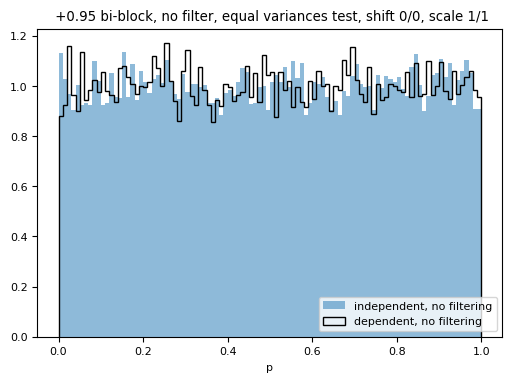

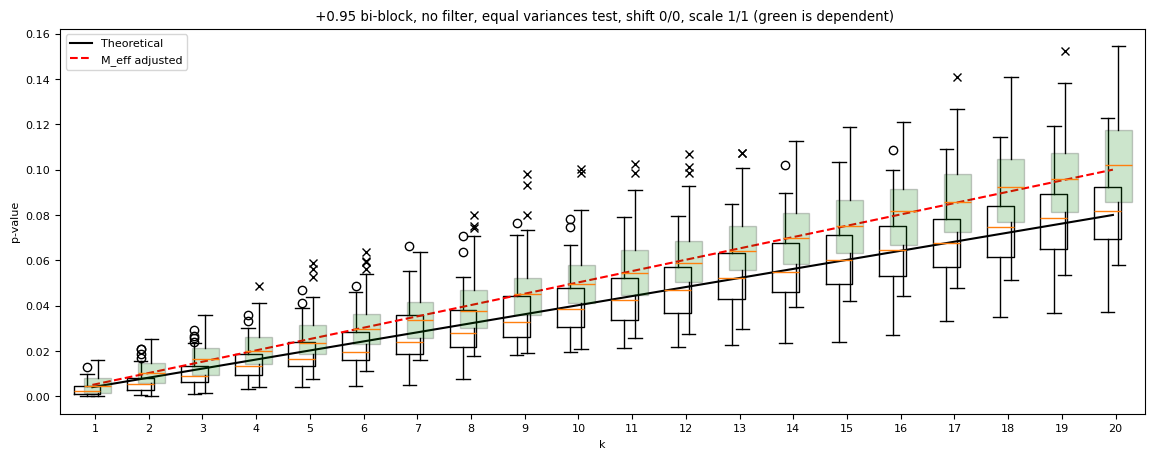

In [18]:
n_times=100
n_jobs = psutil.cpu_count(logical=False)
label0='independent, no filtering'
label1='dependent, no filtering'

it=250
prop=0.0
S0=np.eye(it)#np.eye(it - int(prop*it))

S1= lambda: make_equi_block_covariance(it, 200, 0.999, np.ones(it))
tit = 'CASE50: +0.95 bi-block, no filter, equal variances test, shift 0/0, scale 1/1'
res0=run_experiment_parallel_method_dependent(S0, times=n_times, n_jobs=n_jobs, n1=10, n2=10, equal_var=True, prop=prop, crit='var', return_n=None, statistic='p', shift=0, scale=1)
res1=run_experiment_parallel_method_dependent(S1, times=n_times, n_jobs=8, n1=10, n2=10, equal_var=True, prop=prop, crit='var', return_n=None, statistic='p', shift=0, scale=1)
plot_cases(res0, res1, tit, label0,label1)
plot_others(res0, res1, tit + " (green is dependent)", k=20, M_eff=200)

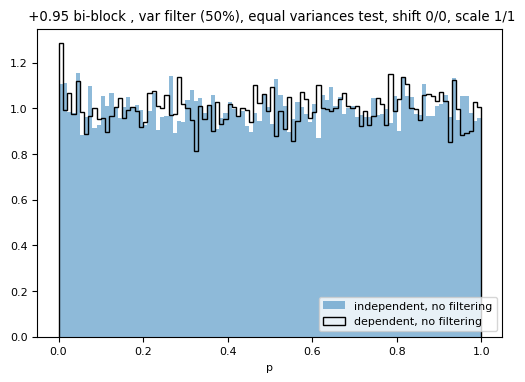

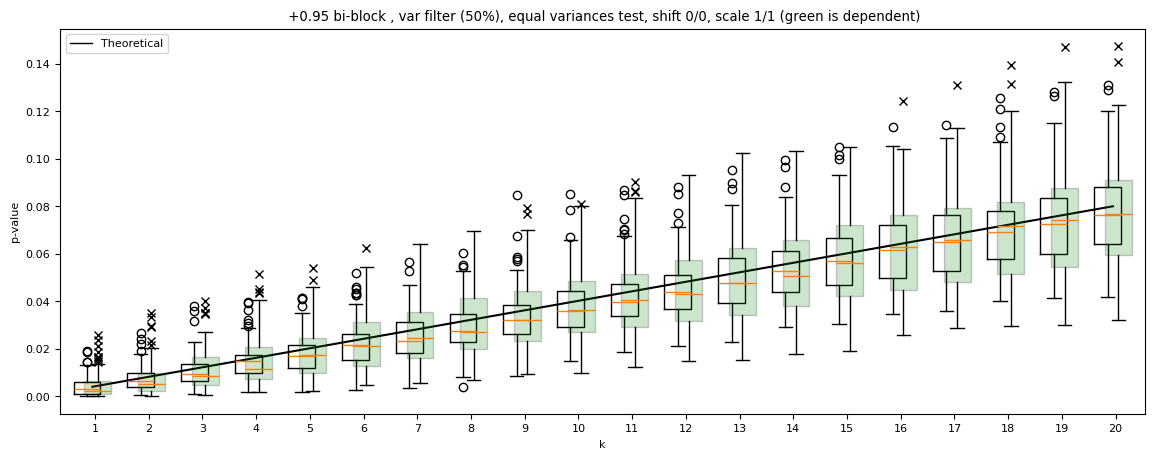

In [638]:
plot_cases(res0, res1, tit, label0,label1)
plot_others(res0, res1, tit + " (green is dependent)", k=20)

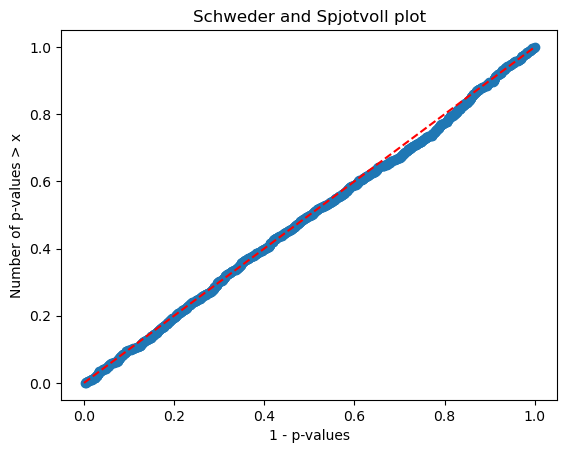

In [503]:
pvalue_plot_spjotvoll(res0.flatten())

In [ ]:
# plot horizontal line at y=0
plt.

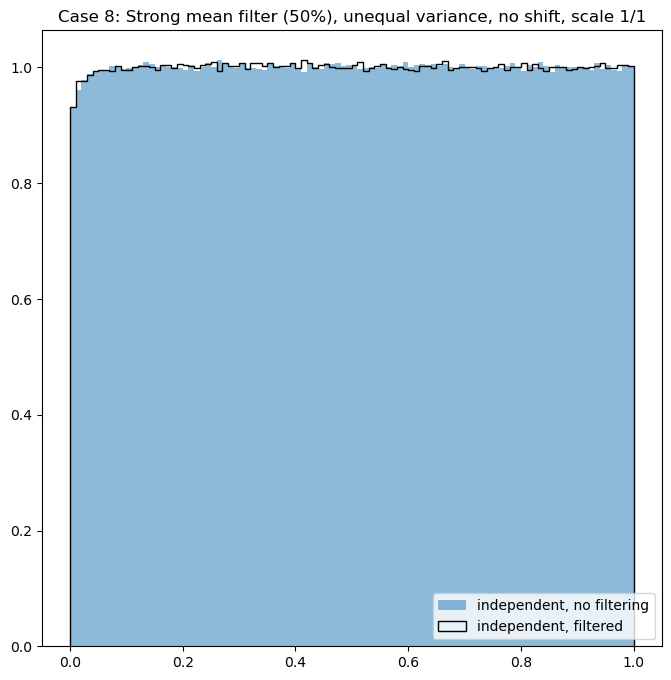

In [504]:
plt.figure(figsize=(8,8))
plt.hist(res0.flatten(), bins=100, alpha=0.5, label=label0, density=True)
plt.hist(res1.flatten(), bins=100, alpha=1, label=label1, histtype=u'step', color='black', density=True)
# plot the axvlines at 0.05 quantile
#plt.axvline(np.quantile(res0.flatten(), 0.05), color='blue', linestyle='--', label='0.05 quantile no filter')
#plt.axvline(np.quantile(res1.flatten(), 0.05), color='red', linestyle='--', label='0.05 quantile filter')
# put legend at the right bottom
plt.legend(loc='lower right')
plt.title(tit)
plt.show()

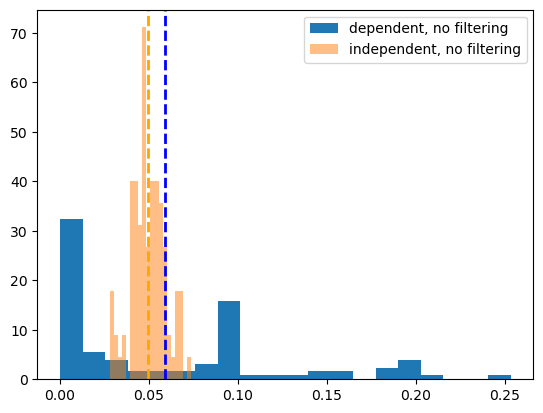

0.0044157400000000005 8.361111111111111e-05


In [332]:
h_dep = np.sum(res0<=0.05,axis=1)/it
h_ind = np.sum(res1<=0.05,axis=1)/it
plt.hist(h_dep, bins=20, alpha=1, label=label0, density=True)
plt.hist(h_ind, bins=20, alpha=0.5, label=label1, density=True)
# plot verticals at means
plt.axvline(np.mean(h_dep), color='blue', linestyle='dashed', linewidth=2)
plt.axvline(np.mean(h_ind), color='orange', linestyle='dashed', linewidth=2)
plt.legend()
plt.show()
print(np.var(h_dep), np.var(h_ind))

In [195]:
prop = 0
it=1000
it = int(it + prop*it)
assert it%2==0
S=make_equi_block_covariance(it, it//2, 0.5, np.ones(it))
#S=np.eye(20)
res0=run_experiment_parallel_method_dependent(S, times=100, it=it, n1=10, n2=10, prop=0, crit='var', return_n=30, statistic='p', shift=0)
res1=run_experiment_parallel_method(times=100, it=it, n1=10, n2=10, prop=0, crit='var', return_n=30, statistic='p', shift=0, scale=1)

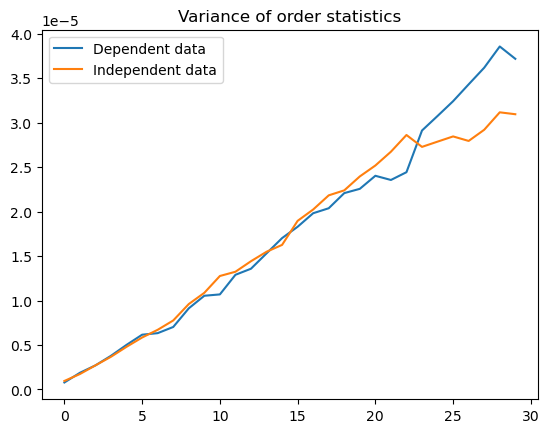

In [197]:
var0 = np.var(res0, axis=0)
var1 = np.var(res1, axis=0)
plt.plot(var0, label='Dependent data')
plt.plot(var1, label='Independent data')
plt.title('Variance of order statistics')
plt.legend()
plt.show()

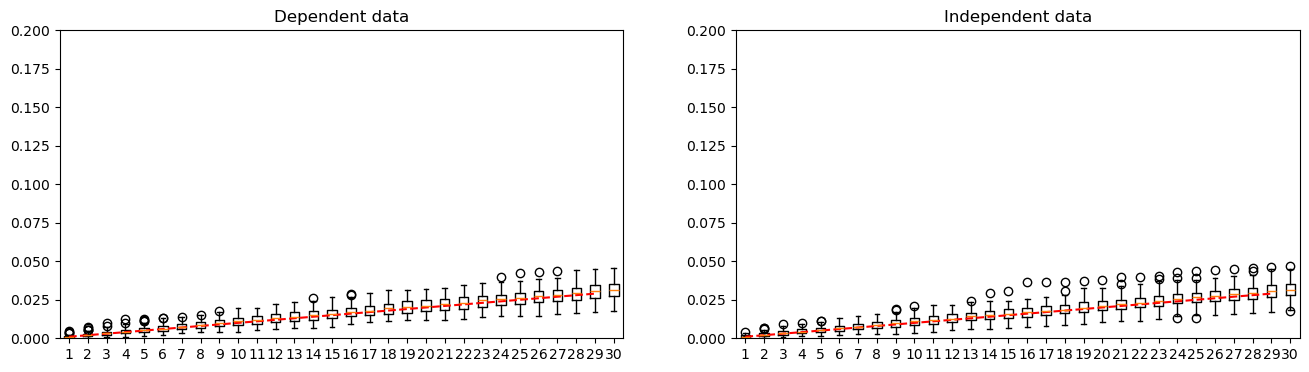

In [198]:
plt.figure(figsize=(16,4))
plt.subplot(121)
plt.boxplot(res0)
plt.plot(np.arange(1,30),np.arange(1,30)/it, color='red', linestyle='dashed')
plt.ylim(0,0.2)
plt.title('Dependent data')
plt.subplot(122)
plt.boxplot(res1)
plt.plot(np.arange(1,30),np.arange(1,30)/it, color='red', linestyle='dashed')
plt.ylim(0,0.2)
plt.title('Independent data')
plt.show()

In [ ]:
remove_proportion_of_testsV1(it=1000, n1=10, n2=10, equal_var=False, prop=0, crit='var', return_n=None, statistic='p', shift=0, scale=1):

In [686]:
shift=.0
scale=2
prop=0.5
it=int(1e5)
res0 = remove_proportion_of_testsV1(it, 10, 10, False, 0, crit='mean', shift=shift, scale=scale)
res1 = remove_proportion_of_testsV1(it, 10, 10, False, prop, crit='mean', shift=shift, scale=scale)
res2 = remove_proportion_of_testsV1(it, 10, 10, False, prop, crit='var', shift=shift, scale=scale)
res3 = remove_proportion_of_testsV1(it, 10, 10, False, prop, crit='fold-change', shift=shift, scale=scale)

C:\Users\paavo\AppData\Local\Temp\ipykernel_41648\2729148401.py:109: DeprecationWarning: Please use `ttest_ind` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  result=stats.ttest_ind(X[:,:n1], X[:,n1:], equal_var=equal_var, axis=1)


In [674]:
res0.shape

(100000,)

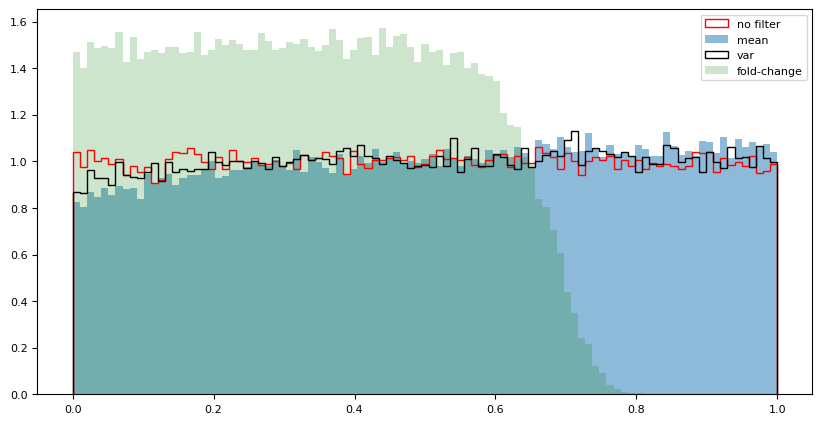

In [687]:
start, end = 0,1
plt.figure(figsize=(10, 5))
plt.hist(res0, bins=np.linspace(start,end, 100), density=True, alpha=1, histtype=u'step', label='no filter', color='red')
plt.hist(res1, bins=np.linspace(start,end, 100), density=True, alpha=0.5, label='mean')
plt.hist(res2, bins=np.linspace(start,end, 100), density=True, alpha=1, label='var', histtype=u'step', color='black')
plt.hist(res3, bins=np.linspace(start,end, 100), density=True, alpha=0.2, label='fold-change', color='green')
plt.legend()
plt.show()

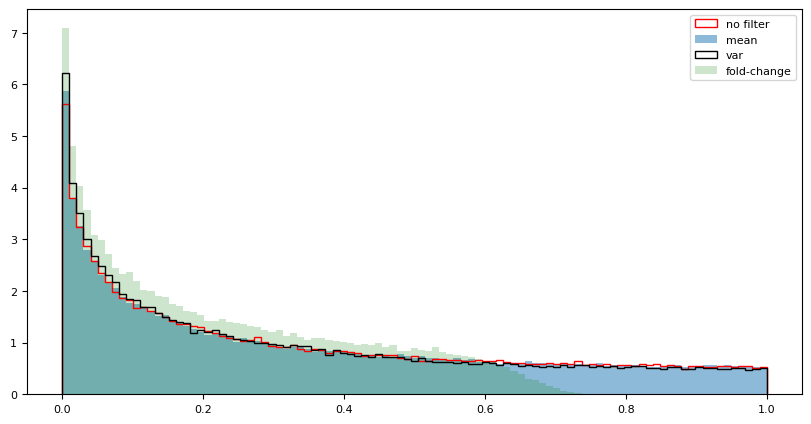

In [681]:
start, end = 0,1
plt.figure(figsize=(10, 5))
plt.hist(res0, bins=np.linspace(start,end, 100), density=True, alpha=1, histtype=u'step', label='no filter', color='red')
plt.hist(res1, bins=np.linspace(start,end, 100), density=True, alpha=0.5, label='mean')
plt.hist(res2, bins=np.linspace(start,end, 100), density=True, alpha=1, label='var', histtype=u'step', color='black')
plt.hist(res3, bins=np.linspace(start,end, 100), density=True, alpha=0.2, label='fold-change', color='green')
plt.legend()
plt.show()

In [104]:
it=1000
ret_n=50
method = 'var'
res = run_experiment_parallel_method(times=50, it=it, n1=10, n2=10, prop=0.3, crit=method, return_n=ret_n)

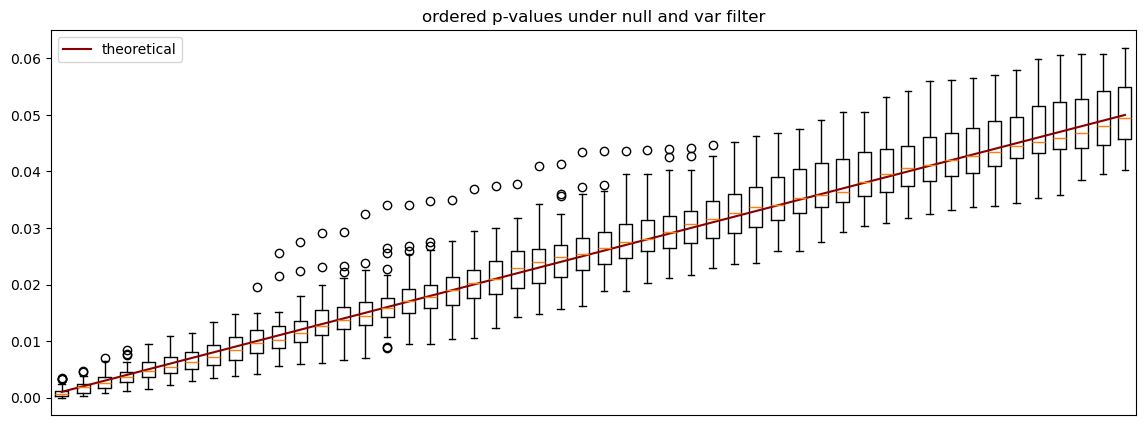

In [105]:
# plot the p-values with different colors for the original and the filtered list
plt.figure(figsize=(14, 5))
plt.boxplot(res,  positions=np.arange(1, ret_n+1, 1), widths=0.6)
#plt.boxplot(res[:, :10])
i = np.arange(1, it, 1)
y = i/it
plt.plot(i[:ret_n], y[:ret_n], color='darkred', label='theoretical')
# set xticks off
plt.xticks([])
plt.legend()
plt.title('ordered p-values under null and ' + method + ' filter')
plt.show()

In [248]:
it=1000
k=10
times=100
res = run_experiment_parallel_invalid(times=times, th=.05, it=it)

In [243]:
res.shape

(100, 20)

In [217]:
res_all = run_experiment_parallel_all(times=times, th=1.3, it=it)

In [123]:
res1 = run_experiment_parallel_method(times=50, it=1000, n1=10, n2=10, prop=0.3, crit='var', return_n=1000)
res2 = run_experiment_parallel_method(times=50, it=1000, n1=10, n2=10, prop=0.3, crit='fold-change', return_n=1000)

In [124]:
res1=res1.flatten()
res2=res2.flatten()

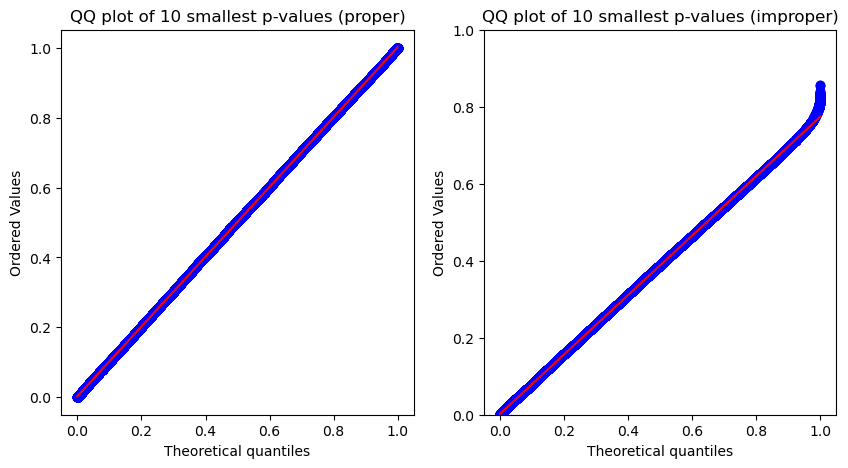

In [128]:
# qq plot res_all[:,0,:].reshape(-1) and res_all[:,1,:].reshape(-1)
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
probplot(res1, dist="uniform", plot=plt)
plt.title("QQ plot of 10 smallest p-values (proper)")
plt.subplot(1,2,2)
probplot(res2, dist="uniform", plot=plt)
plt.title("QQ plot of 10 smallest p-values (improper)")
plt.ylim(0,1)
plt.show()

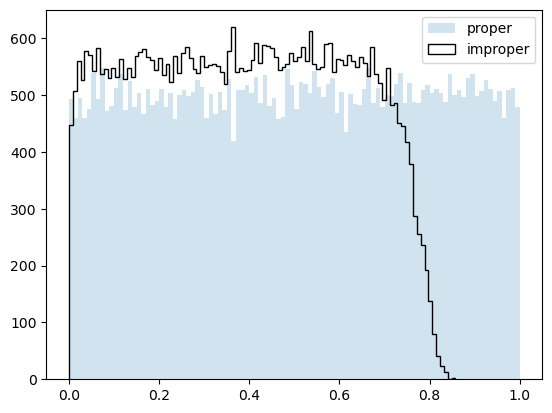

In [126]:
plt.hist(res1, bins=100, alpha=0.2, label='proper')
plt.hist(res2, bins=100, alpha=1, label='improper', histtype=u'step', color='k')
plt.legend()
plt.show()

In [65]:
def topk_elements(x, k, ascending=True, sorted=False):
    # This function returns the top k elements of x. If ascending is True,
    # the smallest k elements are returned. If sorted is True, the output is
    # sorted; otherwise the output order is not guaranteed.
    assert k <= len(x), 'k must be less than or equal to the length of x'
    if ascending:
        indices = np.argpartition(x, k)
    else:
        indices = np.argpartition(x, -k)[::-1]
    if sorted:
        return np.sort(x[indices[:k]])
    else:
        return x[indices[:k]]
    

def filter_indices(arr, val, method='threshold'):
    # arr is the array to filter (e.g., variance, mean, etc.)
    # val is the threshold or proportion to filter by
    # method is either 'threshold' or 'proportion'
    # This function returns a boolean array of the same length as arr
    # where True indicates that the element should be kept and False
    # indicates that the element should be removed.
    if method == 'threshold':
        return np.asarray(arr >= val, dtype=bool)
    elif method == 'proportion':
        k = int(val*len(arr))
        inds = np.argpartition(arr, k)
        out = np.ones_like(arr, dtype=bool)
        out[inds[:k]] = False
        return out
    else:
        raise ValueError('method not recognized')
    
def column_permutation(x, rng):
    # This function randomly permutes the columns of x
    #y = x[:, rng.permutation(x.shape[1])]
    y = rng.permutation(x, axis=1)
    return y

def row_and_column_permutation(x, rng):
    # This function randomly permutes the rows and columns of x
    y = x.flatten()
    y = y[rng.permutation(len(y))].reshape(x.shape)
    return y

def apply_in_batches(func, x, inds_left, inds_right, p=1):
    
    n = x.shape[0]
    K = inds_left.shape[0]
    N = n * K
    result = np.zeros((N,p))
    for i in range(K):
        result[i*n:(i+1)*n] = func(x[:,inds_left[i]], x[:,inds_right[i]])
    return result

